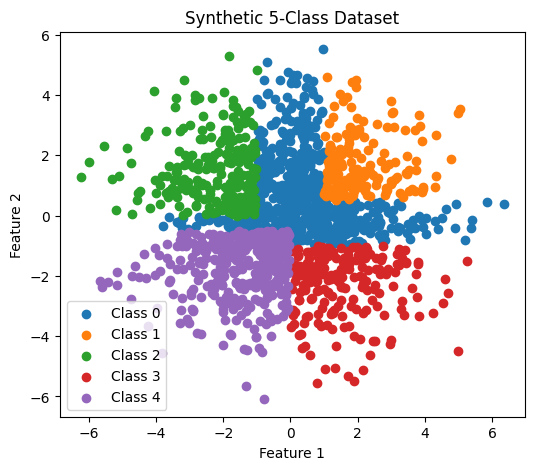

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

np.random.seed(0)


def generate_dataset(n=1500):
    """
    Generates a synthetic 2D dataset with 5 classes.
    Class assignment:
    0 = default
    1 = X[:,0] > 1 & X[:,1] > 0.5
    2 = X[:,0] < -1 & X[:,1] > 0
    3 = X[:,0] > 0 & X[:,1] < -1
    4 = X[:,0] < 0 & X[:,1] < -0.5
    """
    X = np.random.randn(n, 2) * 2
    Y = np.zeros((n,), dtype=int)

    Y[(X[:,0] > 1) & (X[:,1] > 0.5)] = 1
    Y[(X[:,0] < -1) & (X[:,1] > 0)] = 2
    Y[(X[:,0] > 0) & (X[:,1] < -1)] = 3
    Y[(X[:,0] < 0) & (X[:,1] < -0.5)] = 4

    return X, Y

X, Y_raw = generate_dataset(1500)

# One-hot encode labels for multi-class classification
Y = np.eye(5)[Y_raw]

# Shuffle dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X, Y, Y_raw = X[indices], Y[indices], Y_raw[indices]

# Split into training (75%) and testing (25%)
split = int(0.75 * X.shape[0])
X_train, Y_train = X[:split], Y[:split]
X_test, Y_test = X[split:], Y[split:]
Y_test_raw = Y_raw[split:]

# Visualize dataset
plt.figure(figsize=(6,5))
for i in range(5):
    plt.scatter(X[Y_raw==i,0], X[Y_raw==i,1], label=f'Class {i}')
plt.title("Synthetic 5-Class Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()



In [46]:
class NeuralNetwork:
    def __init__(self):
        """
        3-hidden-layer neural network:
        Input: 2 features
        Hidden1: 10 neurons
        Hidden2: 10 neurons
        Hidden3: 10 neurons
        Output: 5 neurons (for 5 classes)
        """
        self.lr = 0.01
        # Weight initialization (small random numbers)
        self.W_H1 = np.random.randn(2,10)*0.1
        self.W_H2 = np.random.randn(10,10)*0.1
        self.W_H3 = np.random.randn(10,10)*0.1
        self.W_O  = np.random.randn(10,5)*0.1

    # Sigmoid for hidden layers
    def sigmoid(self, x, der=False):
        s = 1/(1+np.exp(-x))
        if der:
            return s*(1-s)
        return s

    # Softmax for output
    def softmax(self, x):
        e = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e / np.sum(e, axis=1, keepdims=True)

    # Forward pass
    def feedForward(self, X):
        self.Z1 = np.dot(X, self.W_H1)
        self.A1 = self.sigmoid(self.Z1)

        self.Z2 = np.dot(self.A1, self.W_H2)
        self.A2 = self.sigmoid(self.Z2)

        self.Z3 = np.dot(self.A2, self.W_H3)
        self.A3 = self.sigmoid(self.Z3)

        self.Z4 = np.dot(self.A3, self.W_O)
        self.pred = self.softmax(self.Z4)
        return self.pred

    # Backpropagation
    def backPropagation(self, X, Y, pred):
        m = X.shape[0]

        # Output error
        output_error = (pred - Y)/m

        # Hidden layer 3
        hidden3_error = np.dot(output_error, self.W_O.T)
        hidden3_delta = hidden3_error * self.sigmoid(self.A3, der=True)

        # Hidden layer 2
        hidden2_error = np.dot(hidden3_delta, self.W_H3.T)
        hidden2_delta = hidden2_error * self.sigmoid(self.A2, der=True)

        # Hidden layer 1
        hidden1_error = np.dot(hidden2_delta, self.W_H2.T)
        hidden1_delta = hidden1_error * self.sigmoid(self.A1, der=True)

        # Update weights
        self.W_O  -= self.lr * np.dot(self.A3.T, output_error)
        self.W_H3 -= self.lr * np.dot(self.A2.T, hidden3_delta)
        self.W_H2 -= self.lr * np.dot(self.A1.T, hidden2_delta)
        self.W_H1 -= self.lr * np.dot(X.T, hidden1_delta)

    # Train one step
    def train(self, X, Y):
        pred = self.feedForward(X)
        self.backPropagation(X,Y,pred)
        # Cross-entropy loss
        loss = -np.mean(np.sum(Y * np.log(pred + 1e-8), axis=1))
        return loss

Epoch 0, Loss: 1.6168
Epoch 200, Loss: 1.5157
Epoch 400, Loss: 1.5070
Epoch 600, Loss: 1.5060
Epoch 800, Loss: 1.5058
Epoch 1000, Loss: 1.5058
Epoch 1200, Loss: 1.5057
Epoch 1400, Loss: 1.5057
Epoch 1600, Loss: 1.5057
Epoch 1800, Loss: 1.5057


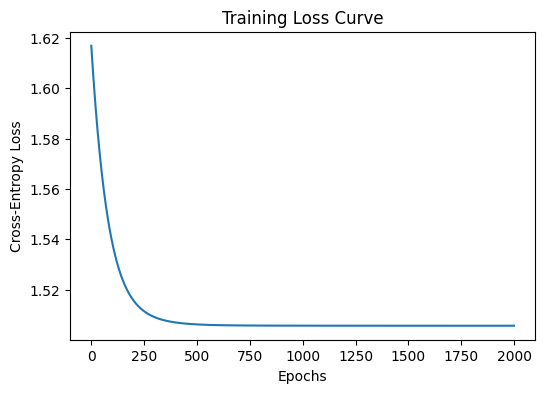

In [47]:
NN = NeuralNetwork()
losses = []

epochs = 2000
for i in range(epochs):
    loss = NN.train(X_train, Y_train)
    losses.append(loss)
    if i % 200 == 0:
        print(f"Epoch {i}, Loss: {loss:.4f}")

plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.show()


Test Accuracy: 0.3626666666666667

Class 0:
 Precision: 0.36266666665699554
 Recall   : 0.9999999999264705
 F1-Score : 0.5322896242529708

Class 1:
 Precision: 0.0
 Recall   : 0.0
 F1-Score : 0.0

Class 2:
 Precision: 0.0
 Recall   : 0.0
 F1-Score : 0.0

Class 3:
 Precision: 0.0
 Recall   : 0.0
 F1-Score : 0.0

Class 4:
 Precision: 0.0
 Recall   : 0.0
 F1-Score : 0.0


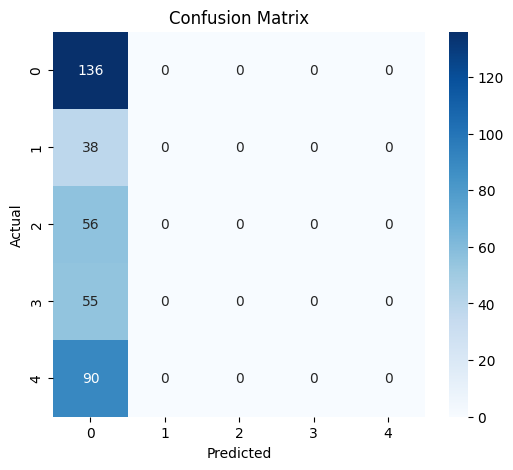

In [48]:
pred_test = NN.feedForward(X_test)
y_pred = np.argmax(pred_test, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Accuracy
accuracy = np.mean(y_pred == y_true)
print("\nTest Accuracy:", accuracy)

# Precision, Recall, F1-Score
num_classes = 5
precision, recall, f1 = [], [], []

for c in range(num_classes):
    TP = np.sum((y_pred == c) & (y_true == c))
    FP = np.sum((y_pred == c) & (y_true != c))
    FN = np.sum((y_pred != c) & (y_true == c))

    prec = TP / (TP + FP + 1e-8)
    rec  = TP / (TP + FN + 1e-8)
    f1_c = 2 * prec * rec / (prec + rec + 1e-8)

    precision.append(prec)
    recall.append(rec)
    f1.append(f1_c)

    print(f"\nClass {c}:")
    print(" Precision:", prec)
    print(" Recall   :", rec)
    print(" F1-Score :", f1_c)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Observations:

Class 0 is mostly predicted correctly, but Classes 1–4 are often misclassified. Overall test accuracy is low because the network favors Class 0.

Key Findings:

The network struggles due to small hidden layers and sigmoid activation, which cause vanishing gradients. Softmax with cross-entropy is correct, but the network cannot separate all five classes effectively.

Challenges:

Classes 1–4 are hard to learn. Sigmoid slows training and deeper layers have very small gradients. Learning rate and weight initialization may also limit performance.

Improvements:

Use ReLU in hidden layers, increase neurons or layers, try Adam optimizer, and ensure more separable or balanced classes.

Lessons Learned:

Multi-class classification needs careful network design, activation choice, and hyperparameter tuning. Visualizations like loss curves and confusion matrices help identify misclassification patterns.